In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import random
from grid import *
from wfc import *
from utils import *
from floor import *
import cv2 as cv
import os

file calledfloor_1_small.png
file calledfloor_2_small.png
file calledfloor_3_small.png
file calledfloor_4_small.png
file calledfloor_5_small.png


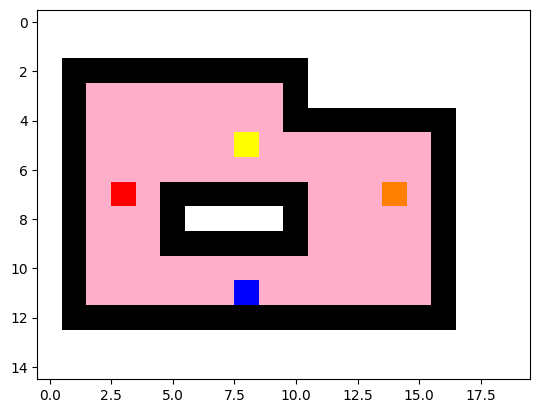

In [2]:
floorplans = []
data_dir = "data/pre_defined/small/"
for filename in os.listdir(data_dir):
    if filename.lower().endswith(('.png', 'jpeg')):
        print(f"file called{filename}")
        filepath = os.path.join(data_dir, filename)
        floorplan = cv.imread(filepath)
        floorplan = cv.cvtColor(floorplan, cv.COLOR_BGR2RGB)
        plt.imshow(floorplan)
        floorplans.append(floorplan)

In [3]:
def plot_rect(size, rect):
    fig, axes = plt.subplots(size[1], size[0], figsize=size, gridspec_kw={'wspace': 0, 'hspace': 0})
    show = True
    for ax, row in zip(axes.flatten(), rect.flatten()):
        image_data = np.array(row.ins, dtype=float)
        ax.imshow(image_data, cmap='gray', aspect='auto')
        ax.axis('off')


    plt.tight_layout()
    plt.show()

def int_to_wall(rect, Wall=Wall):
    """
    Converts a numpy array of integers to an array of Wall objects.
    Each integer is transformed to Wall(n) where n is the integer value.
    """
    return np.vectorize(lambda x: Wall(17) if (((128 <= x) and (144 >= x)) or ((x >18) and (x<=21))) else Wall(x))(rect)

In [4]:
def extract_wall_segments(grid, pixel_size=1, min_run: int = 2):
    """
    Extract horizontal (top edges) and vertical (right edges) wall segments.
    """
    segments = []
    h, w = grid.shape
    room_mask = grid != 0
    # Horizontal runs (top edges)
    for y in range(h):
        run_start = None
        length = 0
        for x in range(w + 1):
            is_wall = x < w and grid[y, x] == 1
            if is_wall:
                if run_start is None:
                    run_start = x + 0.5
                length += 1
            else:
                if run_start is not None and length >= min_run:
                    x0 = run_start * pixel_size
                    x1 = (run_start + length) * pixel_size - 1
                    y_top = (y + 0.5) * pixel_size  # Top edge of the row
                    is_inner = False
                    if y > 0 and y < h-1:
                        x_start = int(np.floor(run_start))
                        x_end = int(np.floor(run_start + length))
                        below_room = room_mask[y, x_start:x_end].all()
                        above_room = room_mask[y+1, x_start:x_end].all()
                        is_inner = below_room and above_room
                    segments.append(((x0, y_top), (x1, y_top), is_inner))
                run_start = None
                length = 0

    # Vertical runs (right edges)
    for x in range(w):
        run_start = None
        length = 0
        for y in range(h + 1):
            is_wall = y < h and grid[y, x] == 1
            if is_wall:
                if run_start is None:
                    run_start = y + 0.5
                length += 1
            else:
                if run_start is not None and length >= min_run:
                    y0 = run_start * pixel_size
                    y1 = (run_start + length) * pixel_size - 1
                    x_right = (x + 0.5) * pixel_size  # Right edge of the column
                    is_inner = False
                    if x > 0 and x < w-1:
                        y_start = int(np.floor(run_start))
                        y_end = int(np.floor(run_start + length))
                        left_room = room_mask[y_start:y_end, x].all()
                        right_room = room_mask[y_start:y_end, x+1].all()
                        is_inner = left_room and right_room
                    
                    segments.append(((x_right, y0), (x_right, y1), is_inner))
                run_start = None
                length = 0

    return segments

def extract_rooms(grid: np.ndarray):
    """
    Extract room cell coordinates for grid values not 0, 1, 2, 3, or 4.
    """
    rooms = []
    # Create a mask for cells not in {0,1,2,3,4}
    mask = ~np.isin(grid, [0, 1, 2, 3, 4])
    ys, xs = np.where(mask)
    for y, x in zip(ys, xs):
        rooms.append((x, y))  # Store cell indices (like interiors)
    return rooms


def extract_door_points(grid: np.ndarray) -> list[dict]:
    """
    Improved door detection with proper positioning
    """
    doors = []
    h, w = grid.shape

    # Horizontal doors (between rows)
    for y in range(h-1):
        for x in range(w):
            if grid[y, x] == 4 and grid[y+1, x] == 4:
                doors.append({
                    'x': x + 0.5,
                    'y': y + 1,
                    'orientation': 'h'
                })

    # Vertical doors (between columns)
    for x in range(w-1):
        for y in range(h):
            if grid[y, x] == 4 and grid[y, x+1] == 4:
                doors.append({
                    'x': x + 1,
                    'y': y + 0.5,
                    'orientation': 'v'
                })

    return doors


def parse_grid_to_blueprint(grid, pixel_size = 1,min_wall_run: int = 2):
    """
    High-level parsing function.

    Returns a dictionary with:
      - 'wall_segments': list of ((x0,y0),(x1,y1))
      - 'door_centers': list of (x,y)
      - 'interior_cells': list of (x,y)
    """
    walls = extract_wall_segments(grid, pixel_size, min_wall_run)
    doors = extract_door_points(grid)
    interiors = []
    ys, xs = np.where(grid == 4)
    for y, x in zip(ys, xs):
        #interiors.append((x + 0.5, y + 0.5))
        interiors.append((x, y))

    rooms = extract_rooms(grid)  # Extract room cells
    return {
        'wall_segments': walls,
        'door_centers': doors,
        'interior_cells': interiors,
        'room_cells': rooms  # Include room cells in the output
    }


def visualize_blueprint(parsed, 
                       figsize=(8,8), 
                       outer_wall_width=4,
                       inner_wall_width=2,
                       door_radius=0.4,
                       door_color='red',
                       room_fc='#a5d8f5',
                       show_rooms=True):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_facecolor('white')

    # Draw rooms
    if show_rooms:
        for (ix, iy) in parsed['room_cells']:
            rect = Rectangle((ix, iy), 1, 1, 
                           facecolor=room_fc, edgecolor='none', zorder=0)
            ax.add_patch(rect)

    # Separate inner and outer walls
    outer_walls = []
    inner_walls = []
    for segment in parsed['wall_segments']:
        if segment[2]:  # is_inner flag
            inner_walls.append(segment[:2])
        else:
            outer_walls.append(segment[:2])

    # Draw outer walls
    if outer_walls:
        lc = LineCollection(outer_walls, 
                           linewidths=outer_wall_width, 
                           colors='black', 
                           zorder=2)
        ax.add_collection(lc)
    
    # Draw inner walls
    if inner_walls:
        lc = LineCollection(inner_walls, 
                           linewidths=inner_wall_width, 
                           colors='#666666', 
                           zorder=1)
        ax.add_collection(lc)

    # Draw doors with proper semicircle orientation
    for door in parsed['door_centers']:
        x, y = door['x'], door['y']
        orientation = door['orientation']
        
        # Draw white gap first
        if orientation == 'h':
            ax.plot([x-door_radius, x+door_radius], [y, y], 
                    color='white', linewidth=outer_wall_width+2, zorder=3)
            arc = Arc((x, y), door_radius*2, door_radius*2,
                      theta1=0, theta2=180, color=door_color, zorder=4)
        else:
            ax.plot([x, x], [y-door_radius, y+door_radius], 
                    color='white', linewidth=outer_wall_width+2, zorder=3)
            arc = Arc((x, y), door_radius*2, door_radius*2,
                      theta1=270, theta2=90, color=door_color, zorder=4)
        
        ax.add_patch(arc)

    ax.invert_yaxis()
    ax.autoscale()
    plt.tight_layout()
    return fig, ax

In [5]:
import numpy as np
from scipy import ndimage

def place_windows(grid, window_value=5, window_size=8, min_spacing=4):
    new_grid = np.copy(grid)
    h, w = grid.shape

    outside_mask = (grid == 0)
    struct = ndimage.generate_binary_structure(2, 1)
    dilated_outside = ndimage.binary_dilation(outside_mask, structure=struct)
    wall_mask = (grid == 1)
    exterior_walls = dilated_outside & wall_mask

    y_coords, x_coords = np.where(exterior_walls)

    for y, x in zip(y_coords, x_coords):
        if new_grid[y, x] == window_value:
            continue

        is_horizontal = False
        if x > 0 and x < w - 1:
            if grid[y, x-1] == 1 and grid[y, x+1] == 1:
                is_horizontal = True

        is_vertical = False
        if y > 0 and y < h - 1:
            if grid[y-1, x] == 1 and grid[y+1, x] == 1:
                is_vertical = True

        if not (is_horizontal or is_vertical):
            continue

        segment = []
        if is_horizontal:
            left = x
            while left >= 0:
                if grid[y, left] != 1 or not exterior_walls[y, left]:
                    break
                left -= 1
            left += 1

            right = x
            while right < w:
                if grid[y, right] != 1 or not exterior_walls[y, right]:
                    break
                right += 1
            right -= 1

            segment = [(y, cx) for cx in range(left, right + 1)]

        elif is_vertical:
            top = y
            while top >= 0:
                if grid[top, x] != 1 or not exterior_walls[top, x]:
                    break
                top -= 1
            top += 1

            bottom = y
            while bottom < h:
                if grid[bottom, x] != 1 or not exterior_walls[bottom, x]:
                    break
                bottom += 1
            bottom -= 1

            segment = [(cy, x) for cy in range(top, bottom + 1)]

        seg_len = len(segment)
        needed = window_size + 2 * min_spacing
        if seg_len < needed:
            continue

        i = min_spacing
        while i + window_size <= seg_len - min_spacing:
            window_slice = segment[i:i+window_size]
            conflict = False

            for (wy, wx) in window_slice:
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dy == 0 and dx == 0:
                            continue
                        ny = wy + dy
                        nx = wx + dx
                        if 0 <= ny < h and 0 <= nx < w:
                            val = new_grid[ny, nx]
                            if val in [21, 5]:
                                conflict = True
                                break
                    if conflict:
                        break
                if conflict:
                    break

            if not conflict:
                for (wy, wx) in window_slice:
                    new_grid[wy, wx] = window_value
                i += window_size + min_spacing
            else:
                i += 1

    return new_grid

[(1, 3), (1, 13), (2, 13), (2, 17), (5, 2), (5, 3), (5, 9), (5, 11), (7, 13), (7, 17), (10, 2), (10, 13)]
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr


c:\Users\mehds\Documents\EPFL\MA4\Procedural_Building_Generation\ProceduralBuildingGeneration\utils.py:186: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


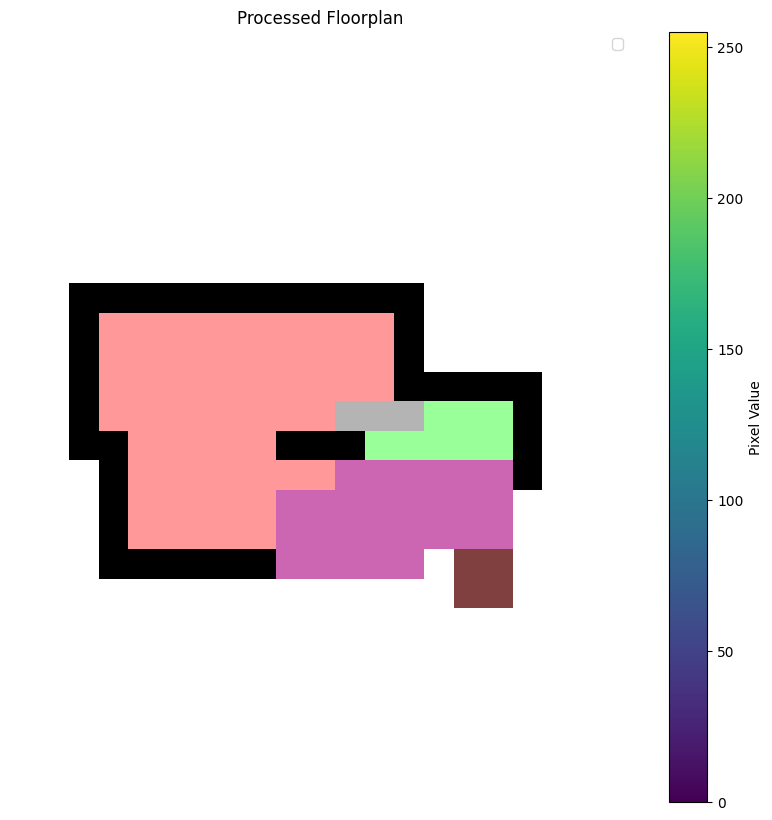

POOOGGGGG[20, 128, 130]
POOOGGGGG[128, 130]
POOOGGGGG[130]


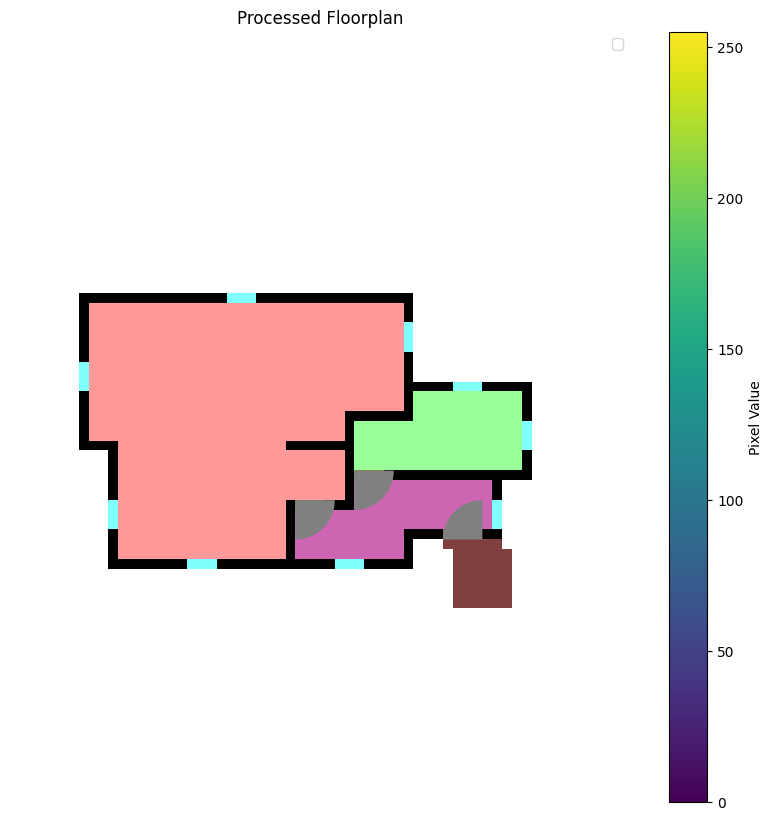

[(1, 5), (1, 14), (2, 2), (2, 5), (2, 14), (2, 18), (8, 2), (8, 13), (11, 13), (11, 18)]
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr


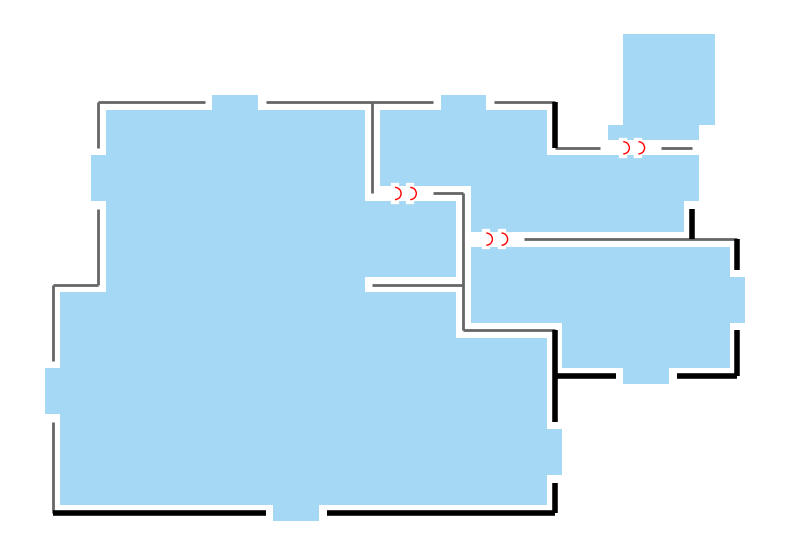

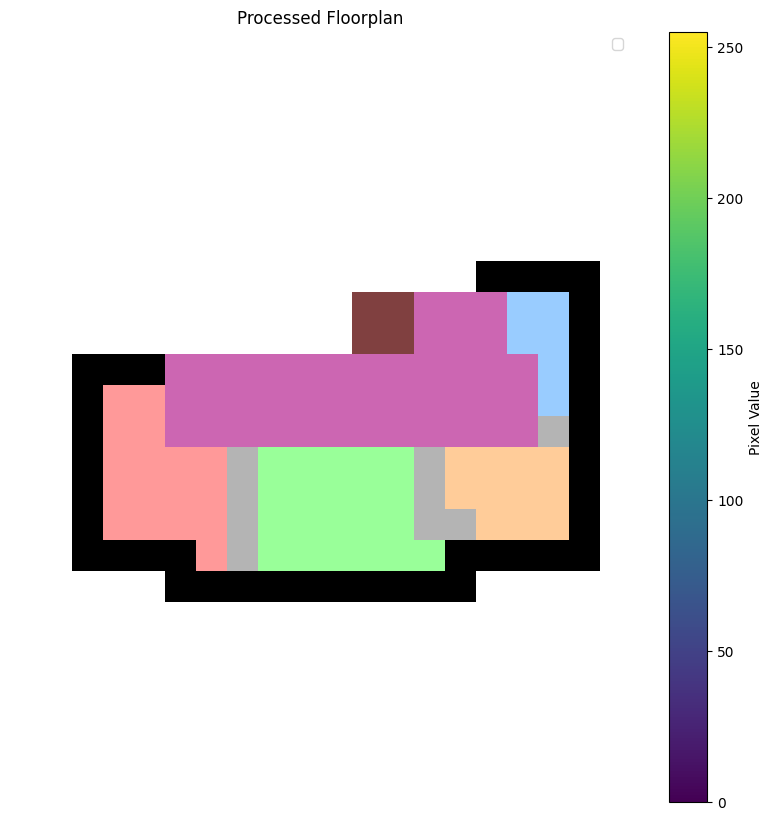

POOOGGGGG[128, 130, 136, 129, 20]
POOOGGGGG[130, 136, 129, 20]
POOOGGGGG[136, 129, 20]
POOOGGGGG[129, 20]
POOOGGGGG[20]


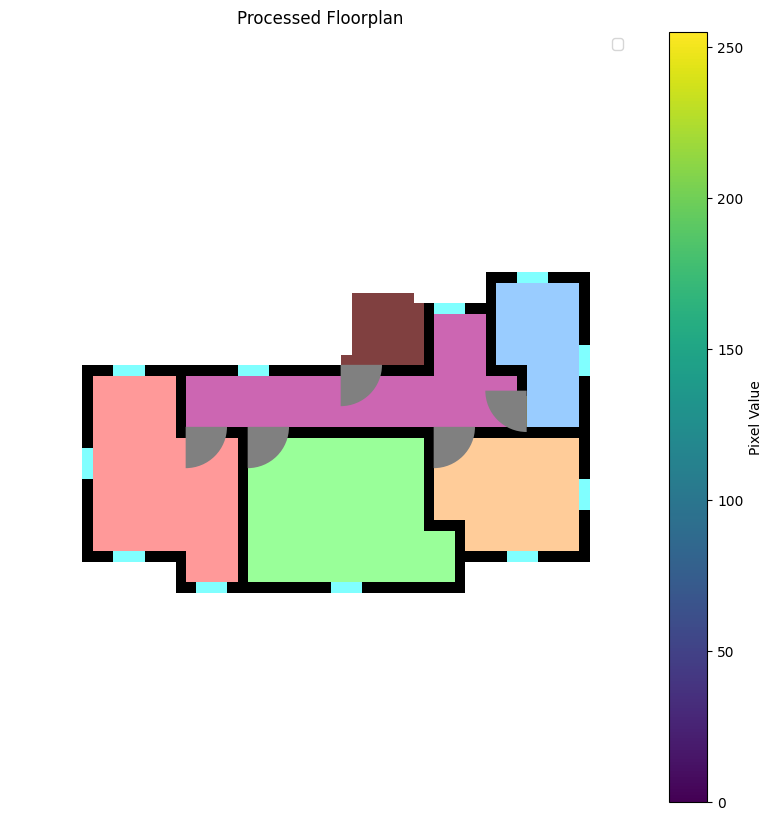

[(1, 1), (1, 18), (6, 7), (6, 12), (11, 1), (11, 7), (11, 12), (11, 18)]


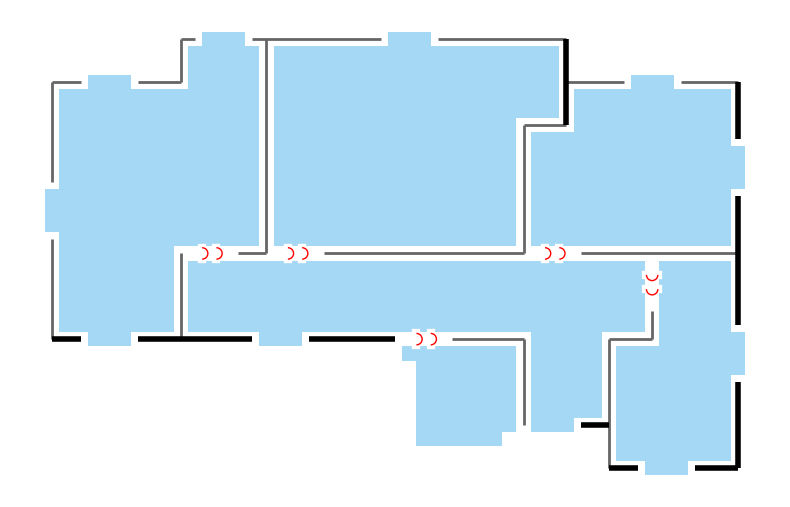

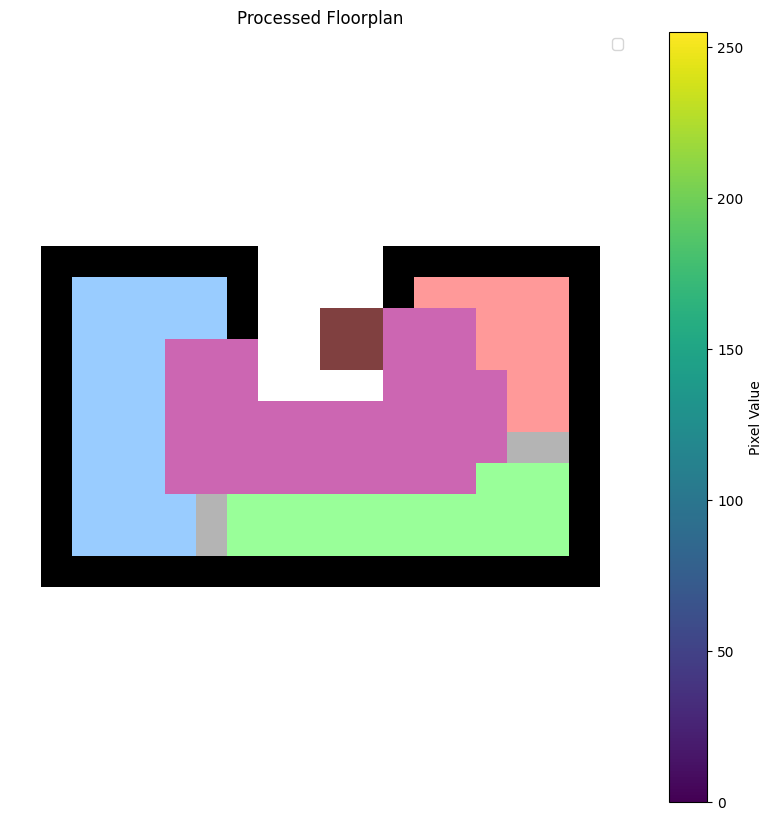

POOOGGGGG[129, 130, 128, 20]
POOOGGGGG[130, 128, 20]
POOOGGGGG[128, 20]
POOOGGGGG[20]


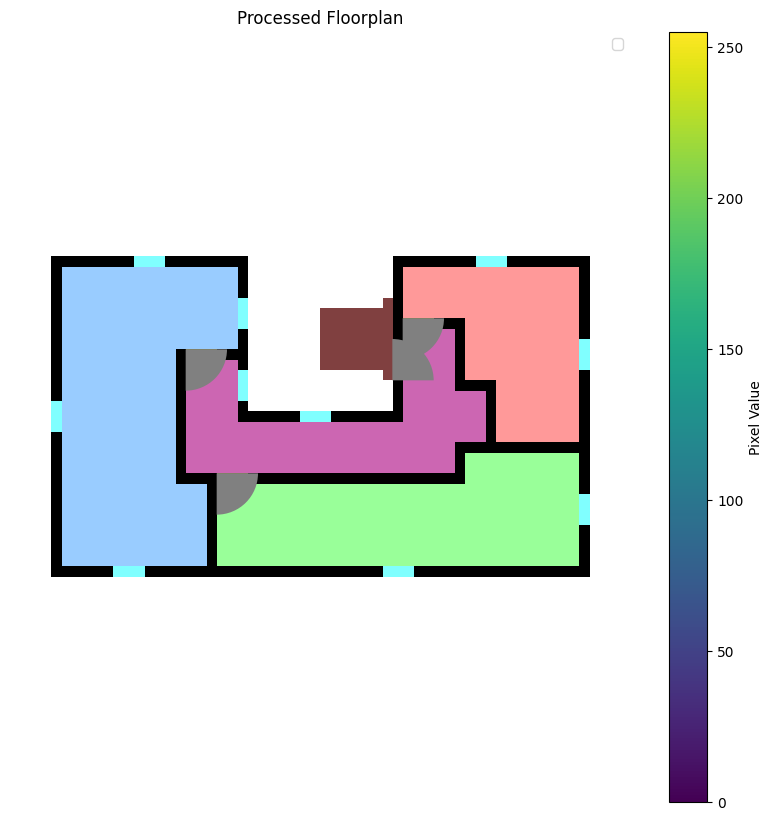

[(1, 1), (1, 10), (11, 1), (11, 10)]


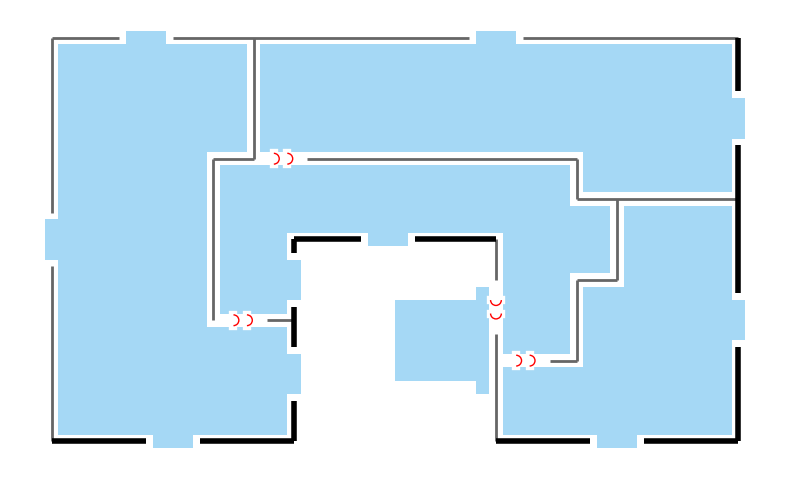

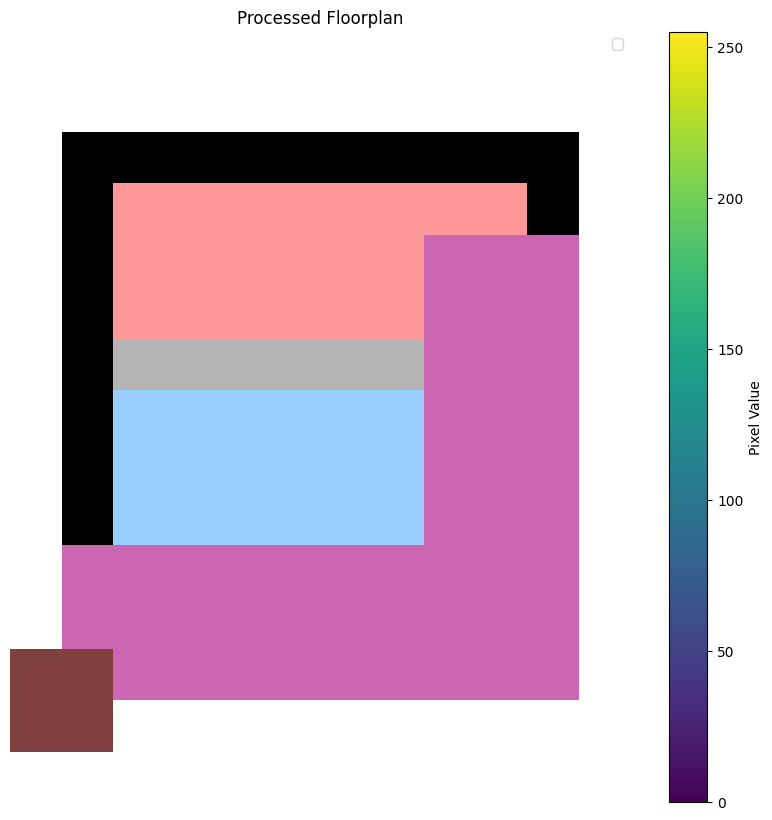

POOOGGGGG[20, 129, 128]
POOOGGGGG[129, 128]
POOOGGGGG[128]


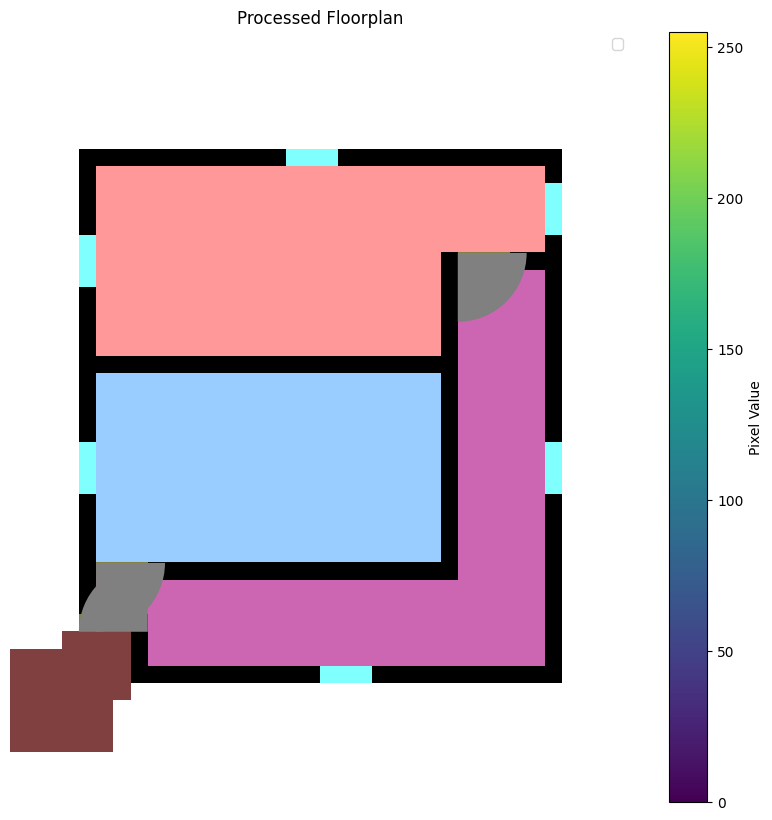

[(2, 1), (2, 10), (4, 10), (4, 16), (7, 5), (7, 10), (9, 5), (9, 10), (12, 1), (12, 16)]
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr
CORNERRRRRRRRRRRRRRRRrrrr


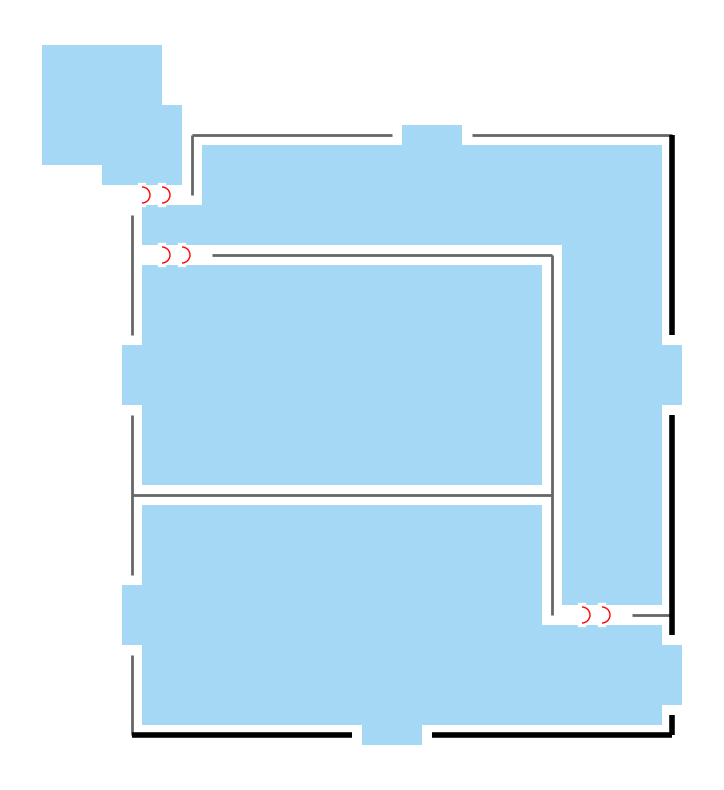

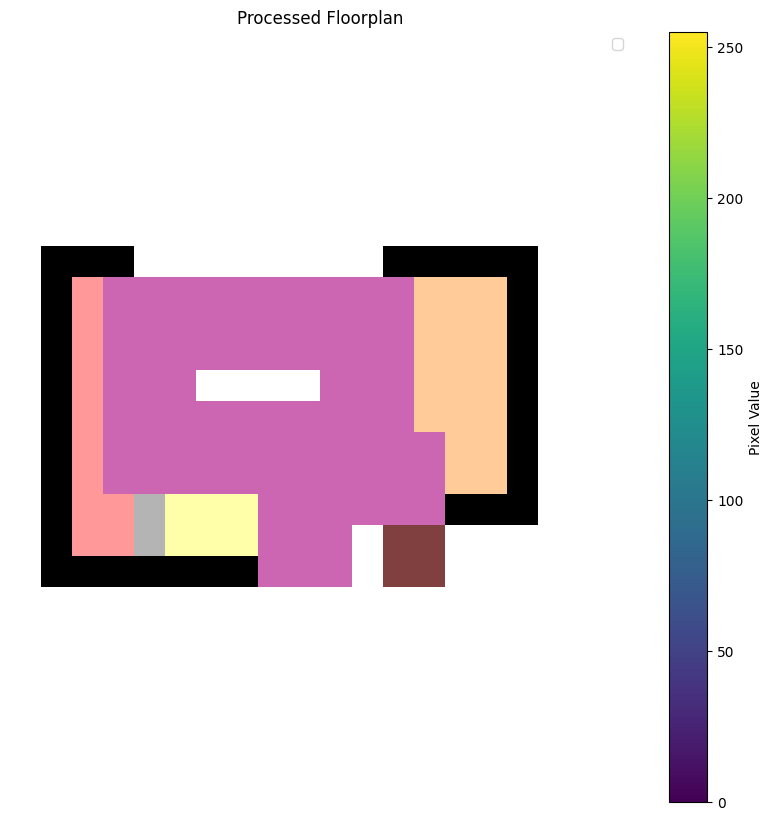

POOOGGGGG[20, 128, 144, 136]
POOOGGGGG[128, 144, 136]
POOOGGGGG[144, 136]
POOOGGGGG[136]


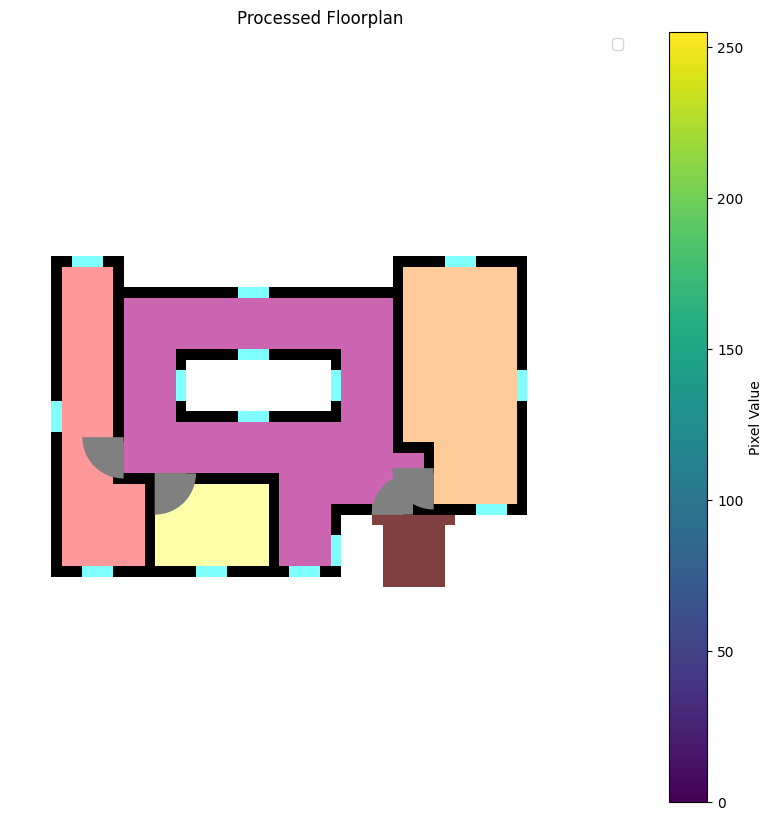

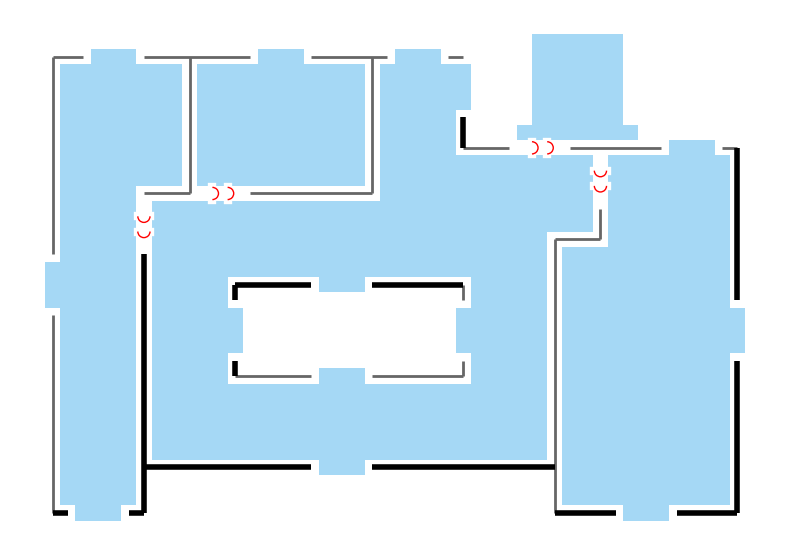

In [6]:
floorplans_int = []
all_seeds = []
from floor import FloorPlan



for floorplan in floorplans:
    floorplan_int, seed_list = image_to_int(floorplan)
    fp = FloorPlan(floorplan_int, seed_list)
    #print(floorplan.shape)
    # Optionally plot the floorplan with seed locations
    # plot_floorplan(floorplan_int, seed_list)
    
    floorplans_int.append(floorplan_int)
    #fp.grid = make_organic_walls(fp.grid)

    #fp.generate_wfc()
    #fp.visualize()
    fp.grow_regions(rectangular=True)
    #fp.show()
    # Optionally generate mapping rectangles, fill rooms and refine walls
    #fp.generate_mapping_rectangles()
    fp.generate_stairs()
    fp.generate_corridors()
    
    # Display the result
    fp.show()
    fp.go_to_3x3()
    #print(fp.grid)
    fp.go_to_3x3int()
    #plt.imshow(fp.room_grid, cmap="viridis", vmin=0, vmax=255)
    #fp.corridor_into_room()
    fp.show(show_doors=True)
    grid_to_plot = parse_grid_to_blueprint(fp.grid)
    
    #print(grid_to_plot)
    visualize_blueprint(grid_to_plot)
    #fp.set_grid(int_to_wall(fp.grid))
    #print(fp.grid)
    #print(f"this is cell {np.array(fp.grid[1][1].ins).shape}")
    #plot_rect((fp.grid.shape[1], fp.grid.shape[0]), fp.grid)
    #horizontal_walls, vertical_walls = parse_grid_to_blueprint(fp.grid)
    #horiz_segments = extract_segments(horizontal_walls, is_horizontal=True)
    #vert_segments = extract_segments(vertical_walls, is_horizontal=False)
    #plot_blueprint(horiz_segments, vert_segments, len(fp.grid), len(fp.grid[0]))

    
    #generate_svg(grid_svg, cell_size=10, output_file="complex_layout.svg")


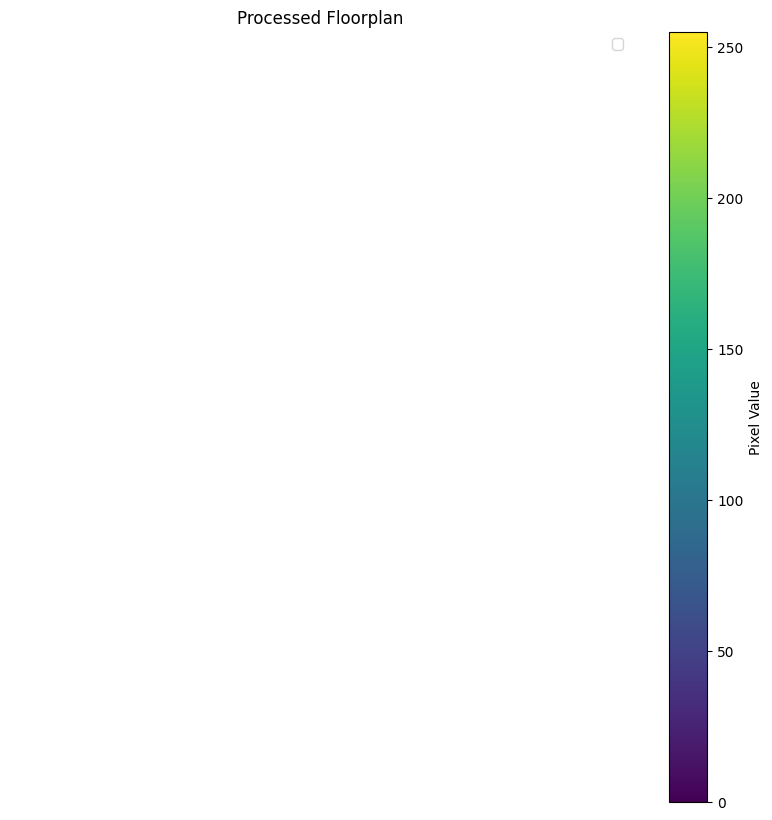

Attempt 1
Cell: <wfc.WFCell object at 0x000001772786B250> and its options [<Wall.DOWN: 4>, <Wall.DOWNLEFT: 12>, <Wall.VERT: 5>, <Wall.UP: 1>, <Wall.UPRIGHT: 3>, <Wall.CROSS: 15>, <Wall.EMPTY: 0>, <Wall.T_DOWN: 14>, <Wall.T_RIGHT: 7>, <Wall.UPLEFT: 9>, <Wall.DOWNRIGHT: 6>, <Wall.HORIZ: 10>, <Wall.T_UP: 11>, <Wall.T_LEFT: 13>]
Is collapsed: False and options: [<Wall.DOWN: 4>, <Wall.DOWNLEFT: 12>, <Wall.VERT: 5>, <Wall.UP: 1>, <Wall.UPRIGHT: 3>, <Wall.CROSS: 15>, <Wall.EMPTY: 0>, <Wall.T_DOWN: 14>, <Wall.T_RIGHT: 7>, <Wall.UPLEFT: 9>, <Wall.DOWNRIGHT: 6>, <Wall.HORIZ: 10>, <Wall.T_UP: 11>, <Wall.T_LEFT: 13>]
Is collapsed: False and options: [<Wall.DOWN: 4>, <Wall.DOWNLEFT: 12>, <Wall.VERT: 5>, <Wall.UP: 1>, <Wall.UPRIGHT: 3>, <Wall.CROSS: 15>, <Wall.EMPTY: 0>, <Wall.T_DOWN: 14>, <Wall.T_RIGHT: 7>, <Wall.UPLEFT: 9>, <Wall.DOWNRIGHT: 6>, <Wall.HORIZ: 10>, <Wall.T_UP: 11>, <Wall.T_LEFT: 13>]
Is collapsed: True and options: [<Wall.CROSS: 15>]
Is collapsed: False and options: [<Wall.DOWN: 4>, 

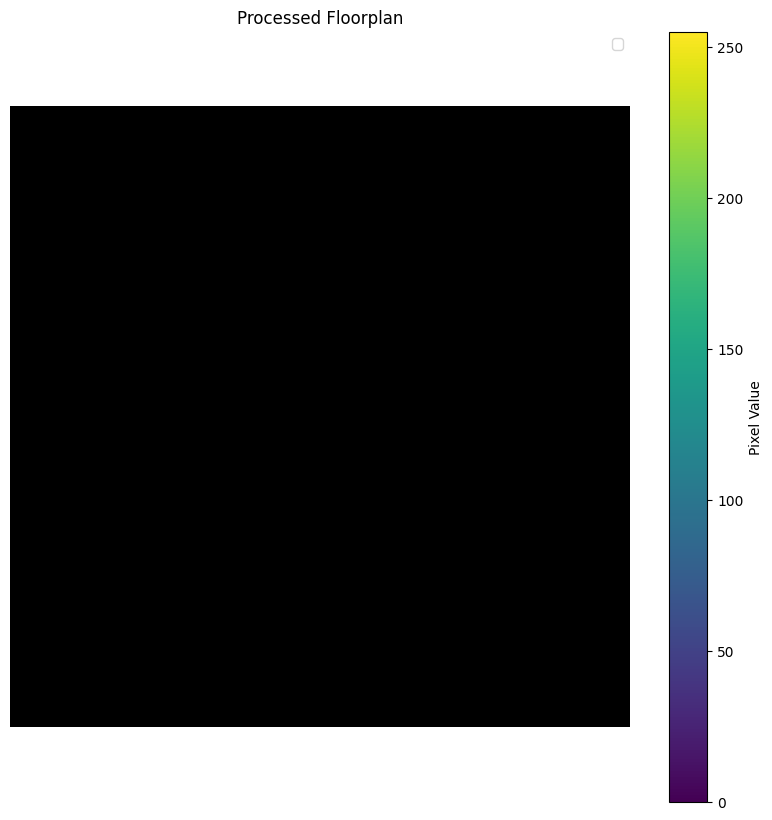

In [7]:

grid_simple = [
    [0, 0, ],
    [0, 0, ],
]
fp = FloorPlan(np.array(grid_simple), seeds=[])
    # Optionally plot the floorplan with seed locations
    # plot_floorplan(floorplan_int, seed_list)
    

fp.show()
fp.generate_wfc()
fp.go_to_3x3()
    #print(fp.grid)
fp.go_to_3x3int()
    #plt.imshow(fp.room_grid, cmap="viridis", vmin=0, vmax=255)
    #fp.corridor_into_room()

fp.show()

